# Homework 1



## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 

In [0]:
# libraries for dataset preparation, feature engineering
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

np.random.seed(123) #for reprodicible results
%matplotlib inline

## 2 - Dataset preparation ##


The dataset ("news_dataset.csv") containing a set of Vietnamses news labeled as doi_song, khoa_hoc, kinh_doanh


In [0]:
# 1. Code to read csv file into Google colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1.1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 1.2. Get the file
data_train = drive.CreateFile({'id':'1_GQgqF2ywAxlLAazDgWfQ51VgV4QponP'}) # replace the id with id of file you want to access
data_train.GetContentFile('news_dataset.csv')  

df = pd.read_csv('news_dataset.csv', header = 0) 

label = np.array(df.iloc[1:, 1])


In [0]:
# The dataframe has two columns, text and label 
df.head()

text     label
0  ﻿Có thể vì quá bận rộn  nhút nhát hoặc quá buồ...  doi_song
1  ﻿ Xoài cát cá trê Cho xoài ướp vào trộn đều vớ...  doi_song
2  ﻿Chuyện nghe có vẻ nghịch lý lại là sự thật 10...  doi_song
3  ﻿Thỉnh thoảng để cha mẹ chú ý đến mình hay trá...  doi_song
4  ﻿Chim muốn bay đường dài đều phải biết lượn. C...  doi_song

In [0]:
size_doi_song = df[df['label'] == "doi_song"].shape[0]
size_khoa_hoc = df[df['label'] == "khoa_hoc"].shape[0]
size_kinh_doanh = df[df['label'] == "kinh_doanh"].shape[0]
print('Number of doi song documents: %s' %size_doi_song)
print('Number of khoa hoc documents: %s' %size_khoa_hoc)
print('Number of kinh doanh documents: %s' %size_kinh_doanh)

Number of doi song documents: 200
Number of khoa hoc documents: 200
Number of kinh doanh documents: 200


In [0]:
# an example of a doi_song news
df['text'][4]

'\ufeffChim muốn bay đường dài đều phải biết lượn. Chúng phần lớn có đôi cánh rộng và thân hình uyển chuyển  sau khi ra sức vỗ cánh sẽ thư giãn xòe rộng đôi cánh  chậm rãi bay lượn về nơi chân trời. Vì vậy  trong hành trình thiên di  nhìn thì tựa như chúng liên tục vỗ cánh bay  nhưng thực ra phần lớn thời gian chúng đều tận dụng sức nâng của không khí để vừa tiêu trừ căng thẳng  vừa tích trữ sức lực  chuẩn bị cho lần vỗ cánh khác. Người thành công trong dựng nghiệp lớn đều biết cách thư giãn. Họ phần lớn đều có tấm lòng rộng rãi và tính tình cởi mở. Sau những vất vả bận rộn  họ thả lỏng bản thân  tận hưởng sự yên tĩnh  lặng lẽ quan sát sự phát triển của thế giới bên ngoài  tính toán bước phát triển ở tương lai  khôi phục nguyên khí và xung lực.  '

Next, we will split the dataset into training and test sets so that we can train and test classifier. Also, we will encode our target column so that it can be used in our model.

In [0]:
# split the dataset into training and test datasets 
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['text'], df['label'])

# label encode the target variable, encode labels to 0 , 1, or 2
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)
print('["doi_song", "khoa_hoc", "kinh_doanh"] labels corresponds to %s labels' %encoder.transform(["doi_song", "khoa_hoc", "kinh_doanh"]))

["doi_song", "khoa_hoc", "kinh_doanh"] labels corresponds to [0 1 2] labels


The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset.

### TF-IDF Vectors as features
TF-IDF score represents the relative importance of a term in the document and the entire corpus. TF-IDF score is composed by two terms: the first computes the normalized Term Frequency (TF), the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams)

In [0]:
# function to calculate the n most important word in document number docNum
def importantWords(docNum, n, tfidf_vect, x_tfidf):
  
  doc_tfidf = x_tfidf[docNum, :]
  doc_tfidf = zip(doc_tfidf.indices, doc_tfidf.data)
  sorted_doc_tfidf = sorted(doc_tfidf, key=lambda v: v[1], reverse=True)
  #print(sorted_doc_tfidf)

  feature_names = tfidf_vect.get_feature_names()

  for i in range(0, n - 1):
    (index, score) = sorted_doc_tfidf[i]
    print (feature_names[index] + " " + str(score))
    
   

In [0]:
# obtained from https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_stop_word
VietnameseStopWords = ["bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ",
                        "chiếc", "cho", "chứ", "chưa", "chuyện", "có", "có_thể",
                        "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để",
                        "đến_nỗi", "đều", "điều", "do", "đó", "được", "dưới", "gì",
                       "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "một_cách",
                       "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những",
                       "nơi", "nữa", "phải", "qua", "ra", "rằng", "rất", "rồi", "sau",  "sẽ",
                       "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và",
                       "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"]




In [0]:
# Find the 10 most important words in  each newspaper
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, stop_words=VietnameseStopWords)
tfidf_vect.fit(df['text'])
x_tfidf =  tfidf_vect.transform(df['text'])

for i in range(0, len(df)):
  print("The n most important word in document number " + str(i))
  importantWords(i, 10, tfidf_vect, x_tfidf)

The n most important word in document number 0
mạng 0.37713541427304564
chị 0.3071781527775488
net 0.2348255151709617
người 0.21232494274600658
anh 0.1687805661110657
tình 0.1501214158883302
thật 0.14488988875368294
chồng 0.13933206684716373
một 0.13223118801582737
The n most important word in document number 1
xoài 0.5222511150550433
mắm 0.3161847460621321
cá 0.2911362779875787
tỏi 0.27065187201167784
ướp 0.23282195153454616
thìa 0.22382190645216143
rau 0.21160515149116776
trê 0.16641728420856994
rưới 0.15635436155099017
The n most important word in document number 2
h 0.6558805563103491
mình 0.22784867258995076
t 0.20818817951562035
cô 0.19051316271156984
violon 0.14420562527529426
bạn 0.141944209595729
yêu 0.13365495947733408
nhìn 0.12491723430700366
già 0.12132492309308703
The n most important word in document number 3
trẻ 0.6286831824542585
dối 0.3110730929069291
lỗi 0.20331176991588906
hay 0.17487540678068386
phạt 0.1577064740822411
dễ 0.13253422345109267
nói 0.12489516730671911


In [0]:
# Find the 10 most important words in  each catergories
doi_song = " ".join(df[df['label'] == "doi_song"]["text"])
khoa_hoc = " ".join(df[df['label'] == "khoa_hoc"]["text"])
kinh_doanh = " ".join(df[df['label'] == "kinh_doanh"]["text"])

VietnameseStopWords = ["bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ",
                        "chiếc", "cho", "chứ", "chưa", "chuyện", "có", "có_thể",
                        "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để",
                        "đến_nỗi", "đều", "điều", "do", "đó", "được", "dưới", "gì",
                       "khi", "không", "là", "lại", "lên", "lúc", "mà", "mỗi", "một_cách",
                       "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những",
                       "nơi", "nữa", "phải", "qua", "ra", "rằng", "rất", "rồi", "sau",  "sẽ",
                       "so", "sự", "tại", "theo", "thì", "trên", "trước", "từ", "từng", "và",
                       "vẫn", "vào", "vậy", "vì", "việc", "với", "vừa"]


tfidf_vect_by_car = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000, stop_words=VietnameseStopWords)
tfidf_vect_by_car.fit([doi_song, khoa_hoc, kinh_doanh])
x_tfidf_by_car =  tfidf_vect_by_car.transform([doi_song, khoa_hoc, kinh_doanh])


print("The 10 most important words in doi_song: ")
importantWords(0, 10, tfidf_vect_by_car, x_tfidf_by_car)
print("The 10 most important words in khoa_hoc: ")
importantWords(1, 10, tfidf_vect_by_car, x_tfidf_by_car)
print("The 10 most important words in kinh_doanh: ")
importantWords(2, 10, tfidf_vect_by_car, x_tfidf_by_car)

The 10 most important words in doi_song: 
một 0.3363901798055962
người 0.31578023272107647
tôi 0.2252756824803593
trong 0.19445037031916457
con 0.17903771423856718
làm 0.15986150260340534
đến 0.1568148147735198
anh 0.14982535445790007
ở 0.1440904126604685
The 10 most important words in khoa_hoc: 
một 0.3876850396665132
trong 0.2896598929626796
người 0.28553871562377964
thể 0.18633608968026033
ở 0.1557216294484324
học 0.1386481804729899
bạn 0.13217204465471863
nhà 0.13158330503487578
con 0.12039725225786173
The 10 most important words in kinh_doanh: 
giá 0.2593720285094156
trong 0.23171387381054426
đầu 0.2141970425012591
nhà 0.17516831309285177
công 0.17240249762296464
tư 0.15857342027352897
đồng 0.1582661074435415
một 0.14658821990401805
năm 0.1456662814140557


In [0]:
# calculate the tf-idf value for training set and test set
xtrain_tfidf =  tfidf_vect.transform(train_x)
xtest_tfidf =  tfidf_vect.transform(test_x)

In [0]:
# Getting transformed training and testing dataset
print('Number of training documents: %s' %str(xtrain_tfidf.shape[0]))
print('Number of testing documents: %s' %str(xtest_tfidf.shape[0]))
print('Number of features of each document: %s' %str(xtrain_tfidf.shape[1]))
print('xtrain_tfidf shape: %s' %str(xtrain_tfidf.shape))
print('train_y shape: %s' %str(train_y.shape))
print('xtest_tfidf shape: %s' %str(xtest_tfidf.shape))
print('test_y shape: %s' %str(test_y.shape))

Number of training documents: 450
Number of testing documents: 150
Number of features of each document: 5000
xtrain_tfidf shape: (450, 5000)
train_y shape: (450,)
xtest_tfidf shape: (150, 5000)
test_y shape: (150,)


Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs.

**Exercise:**: For convenience, you should now transpose the training and testing numpy-array, and expand the shape of the lable arrays in the axis=0 position.

After this, our training (and test) dataset is a numpy-array where each column represents a document vector. There should be the number of training documents (respectively the number of testing documents) as the number of columns.

In [0]:
### START CODE HERE ###
train_y = np.expand_dims(train_y, axis=0)
test_y = np.expand_dims(test_y, axis=0)

# for convenience in this exercise, we also use toarray() to convert sparse to dense matrix 
xtrain_tfidf =  xtrain_tfidf.T.toarray()
xtest_tfidf =  xtest_tfidf.T.toarray()
### END CODE HERE ###

In [0]:
# New shape 
print('xtrain_tfidf shape: %s' %str(xtrain_tfidf.shape))
print('train_y shape: %s' %str(train_y.shape))
print('xtest_tfidf shape: %s' %str(xtest_tfidf.shape))
print('test_y shape: %s' %str(test_y.shape))

xtrain_tfidf shape: (5000, 450)
train_y shape: (1, 450)
xtest_tfidf shape: (5000, 150)
test_y shape: (1, 150)


## 3 - General Architecture of the learning algorithm ##

It's time to design a simple algorithm to distinguish politics-society news from other news.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

**The below image is an analogy of the network architecture of an image classifier to a text classifier.**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse the results and conclude

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

**Exercise**: Using your code from "Python Basics", implement `sigmoid()`. As you've seen in the figure above, you need to compute $sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions. Use np.exp().

In [0]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [0]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


**Expected Output**: 

<table>
  <tr>
    <td>**sigmoid([0, 2])**</td>
    <td> [ 0.5         0.88079708]</td> 
  </tr>
</table>

### 4.2 - Initializing parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [0]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0.
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [0]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0.0


**Expected Output**: 


<table style="width:15%">
    <tr>
        <td>  ** w **  </td>
        <td> [[ 0.]
 [ 0.]] </td>
    </tr>
    <tr>
        <td>  ** b **  </td>
        <td> 0 </td>
    </tr>
</table>

### 4.3 - Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [0]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = np.float(X.shape[1])
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)                                    # compute activation
    cost = -(1/m) * (np.sum((Y*np.log(A))+ ((1-Y)*np.log(1-A))))     # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (1/m)*(np.dot(X,(A-Y).T))
    db = (1/m)*(np.sum(A-Y))
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [0]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

<table style="width:50%">
    <tr>
        <td>  ** dw **  </td>
      <td> [[ 0.99845601]
     [ 2.39507239]]</td>
    </tr>
    <tr>
        <td>  ** db **  </td>
        <td> 0.00145557813678 </td>
    </tr>
    <tr>
        <td>  ** cost **  </td>
        <td> 5.801545319394553 </td>
    </tr>

</table>

### 4.4 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [0]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w,b,X,Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - learning_rate*dw
        b = b - learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [0]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


**Expected Output**: 

<table style="width:40%">
    <tr>
       <td> **w** </td>
       <td>[[ 0.19033591] [ 0.12259159]] </td>
    </tr>
    <tr>
       <td> **b** </td>
       <td> 1.92535983008 </td>
    </tr>
    <tr>
       <td> **dw** </td>
       <td> [[ 0.67752042] [ 1.41625495]] </td>
    </tr>
    <tr>
       <td> **db** </td>
       <td> 0.219194504541 </td>
    </tr>
</table>

**Exercise:** The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [0]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m), dtype=np.int)
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a news being present
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if (A[0][i] > 0.5):
            Y_prediction[0][i] = 1
        else:
            Y_prediction[0][i] = 0
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction, A

In [0]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)[0]))

predictions = [[1 1 0]]


**Expected Output**: 

<table style="width:30%">
    <tr>
         <td>
             **predictions**
         </td>
          <td>
            [[ 1.  1.  0.]]
         </td>  
   </tr>

</table>


<font color='blue'>
**What to remember:**
You've implemented several functions that:
- Initialize (w,b)
- Optimize the loss iteratively to learn parameters (w,b):
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:
    - Y_prediction_test for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [0]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)[0]
    Y_prediction_train = predict(w,b,X_train)[0]

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Run the following cell to train your model.

In [0]:
print("Classification result of recognizing doi_song's news")
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 0 ] = 1
temp_test_y[temp_test_y != 0 ] = 1

d = model(xtrain_tfidf, temp_train_y, xtest_tfidf, temp_test_y, num_iterations = 3000, learning_rate = .5, print_cost = False)

Classification result of recognizing doi_song's news
train accuracy: 99.33333333333333 %
test accuracy: 93.33333333333333 %


In [0]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [0]:
print("Classification result of recognizing khoa_hoc's news")
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 1 ] = 0
temp_test_y[temp_test_y != 1 ] = 0

d = model(xtrain_tfidf, temp_train_y, xtest_tfidf, temp_test_y, num_iterations = 3000, learning_rate = .5, print_cost = False)

Classification result of recognizing khoa_hoc's news
train accuracy: 100.0 %
test accuracy: 90.66666666666667 %


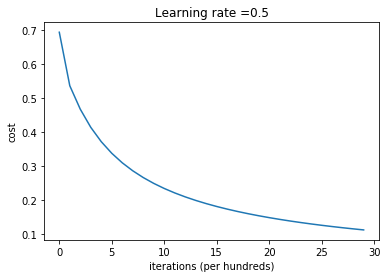

In [0]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [0]:
print("Classification result of recognizing kinh_doanh's news")
temp_train_y = train_y.copy()
temp_test_y = test_y.copy()
temp_train_y[temp_train_y != 2 ] = 1
temp_test_y[temp_test_y != 2 ] = 1

d = model(xtrain_tfidf, temp_train_y, xtest_tfidf, temp_test_y, num_iterations = 3000, learning_rate = .5, print_cost = False)

Classification result of recognizing kinh_doanh's news


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


train accuracy: 66.88888888888889 %
test accuracy: 66.0 %


Let's also plot the cost function and the gradients.

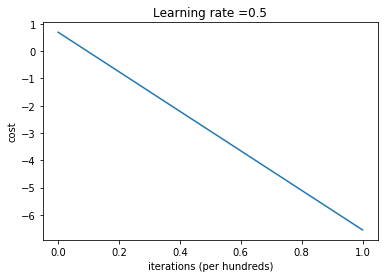

In [0]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()